# Multinomial and Ordinal Logistic Regression

The notebook on Logistic Regression covered the case with two categories or **Binary Logistic Regression**  

This notebook extends to cases where there are multiple categories and the response variable has multiple **nominal** or **ordinal** values.


## Levels of Measurement (Scales of Data)

In statistics and data science, variables can be classified into **four levels of measurement**, based on the properties they possess:

| Level of Measurement | Description                  | Examples                    | Arithmetic Operations Allowed | Appropriate Model (for Response Variable) |
|:--------------------|:------------------------------|:----------------------------|:------------------------------|:------------------------------------------|
| **Nominal**           | No meaningful order between categories; purely labels or names   | Gender, Colors, Product Type    | None     | **Multinomial Logistic Regression**   |
| **Ordinal**           | Can compare order but not exact differences; unknown or unequal spacing | Credit Rating, Satisfaction Level  | Comparison ($<, >$) | **Ordinal Logistic Regression (Proportional Odds Model)**  |
| **Interval**          | Ordered numeric values with **equal intervals**, but no true zero | Temperature (°C, °F), Dates         | $+, −$, comparison   | **Linear Regression (Not Logistic)** | 
| **Ratio**             | Ordered numeric values with true zero point allows for meaningful ratios (e.g., twice as much). | Height, Weight, Age, Income         | $+, −, ×, ÷$, comparison       | **Linear Regression (Not Logistic)** |



### What Model to Use 

**Binary Logistic Regression**
- The outcome is **binary** (two classes)
- You need **interpretable coefficients**
- You care about **probabilities** for decision-making
- The relationship between predictors and outcome is reasonably **linear in the log-odds**

**Multinomial Logistic Regression**
- The outcome has **more than two unordered categories**
- The categories are **mutually exclusive**
- You need to interpret how predictors influence the probability of choosing one class over others
- Simpler tree-based models (like decision trees or random forests) aren’t offering enough interpretability or are overfitting

**Ordinal Logistic Regression**
- The target variable has **ordered, discrete categories**
- You want to maintain the order information
- The proportional odds assumption holds (can be tested)

---

In [1]:
from Visualisations import *

## Binary Logistic Regression  

Recall that in the binary case where there are only two categories $ y \in \{0, 1\} $:

$$
P(y = 1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_p x_p)}}
$$

and the Log-likelihood:

$$
\ln \ell(\beta) = \sum_{i=1}^n \left[ y_i \ln(\sigma (z)) + (1 - y_i) \ln(1 - \sigma (z)) \right]
$$



where the **sigmoid function** $\sigma (z) = \dfrac{1}{1 + e^{-z}}$ maps to a real number $(0, 1)$ representing probability

and $z = ( x_{i}^{\top} \beta)$ represents the linear combination of features for the *i*-th observation. 

The decision boundaries created by the features in the classic iris dataset can be seen in the visualisation below:

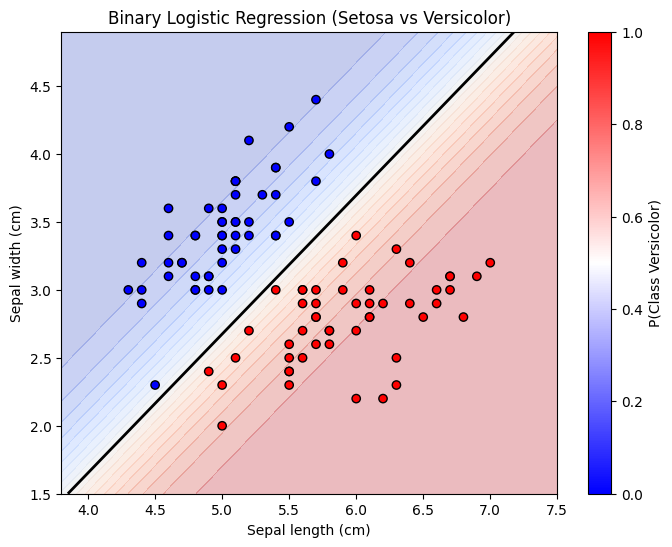

In [2]:
binary_boundary_plot()

**Note on feature selection**:  

Only two features are used in this example (Sepal Width and Sepal Length) for easier visualisation, but there is no limit to the amount of features that can be used. Feature selection through regularisation techniques such as Lasso or reducing dimensions through PCA can help improve model performance and interpretability. 

We can extend this method to create additional decision boundaries to classify more than two categories with **Multinomial Logistic Regression**  

---

### Predicting Credit Ratings

I will use the Corporate Credit Rating dataset from openml using sklearn.  

In [3]:
# Imports
import pandas as pd
from sklearn.datasets import fetch_openml

# Load Corporate Credit Ratings dataset from OpenML
data = fetch_openml(data_id=43344, as_frame=True)

In [4]:
# Print description of dataset
print(data.DESCR)

Context
A corporate credit rating expresses the ability of a firm to repay its debt to creditors. Credit rating agencies are the entities responsible to make the assessment and give a verdict.  When a big corporation from the US or anywhere in the world wants to issue a new bond it hires a credit agency to make an assessment so that investors can know how trustworthy is the company. The assessment is based especially in the financials indicators that come from the balance sheet. Some of the most important agencies in the world are Moodys, Fitch and Standard and Poors. 
Content
A list of 2029 credit ratings issued by major agencies such as Standard and Poors to big US firms (traded on NYSE or Nasdaq) from 2010 to 2016. 
There are 30 features for every company of which 25 are financial indicators. They can be divided in:

Liquidity Measurement Ratios: currentRatio, quickRatio, cashRatio, daysOfSalesOutstanding
Profitability Indicator Ratios: grossProfitMargin, operatingProfitMargin, pret

Cleaning up and engineering categorical variables

In [5]:
# Create DataFrame from data
ratings_df = data.data.copy()

# Convert 'Date' to datetime
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'], format='%m/%d/%Y', errors='coerce')

# Convert relevant columns to nominal category type
categorical_columns = ['Rating_Agency_Name', 'Sector', 'Name', 'Symbol']
for col in categorical_columns:
    ratings_df[col] = ratings_df[col].astype('category')

# Convert 'Rating' to ordered categorical type
rating_order = ['CCC', 'B', 'BB', 'BBB', 'A', 'AA', 'AAA']
ratings_df['Rating'] = pd.Categorical(ratings_df['Rating'], categories=rating_order, ordered=True)

# Create numeric codes for Agency and Sector
ratings_df['Agency_Code'] = ratings_df['Rating_Agency_Name'].cat.codes
ratings_df['Sector_Code'] = ratings_df['Sector'].cat.codes

In [6]:
ratings_df = ratings_df.dropna()

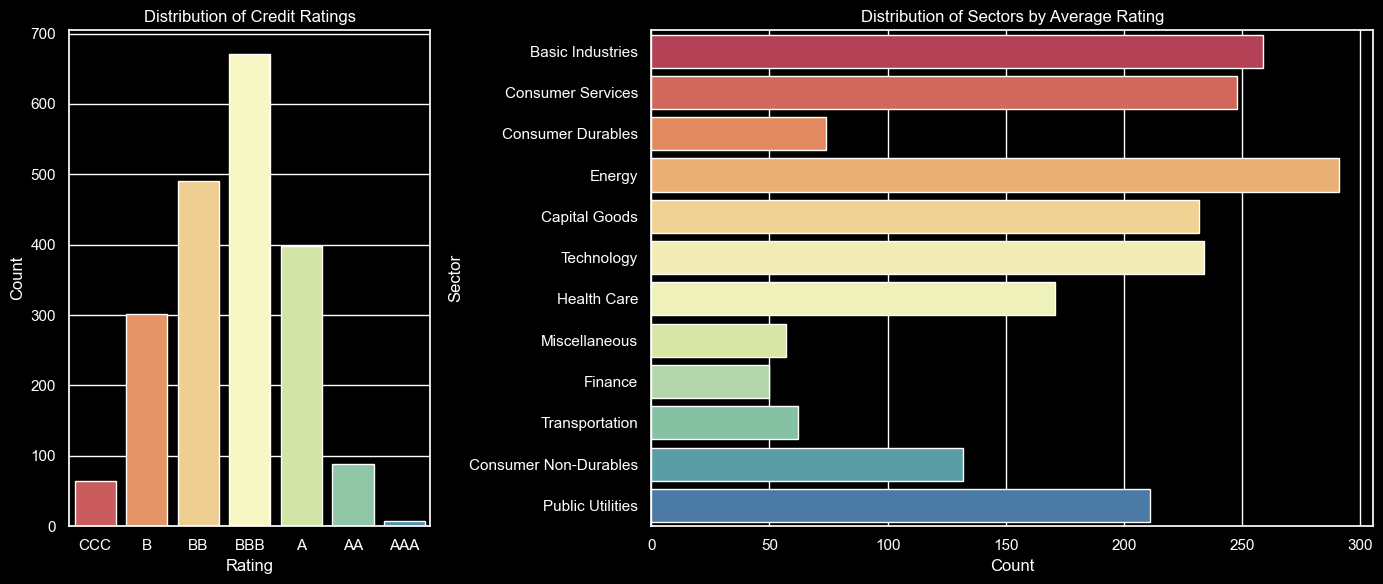

In [7]:
credit_ratings_plot(ratings_df)

In [8]:
# Define feature matrix X and target variable y
X = ratings_df.drop(columns='Rating')
y = ratings_df['Rating']

# Check dataset shapes
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (2021, 33)
Target shape: (2021,)


## Multinomial Logistic Regression

### Baseline Category and Log-Odds Setup

Suppose the response variable $Y$ takes values in the set of categories

$$
Y \in \{1, 2, \ldots, K\}
$$

We choose category $K$ as the **baseline (reference) category**.

For each category $j = 1, 2, \ldots, K-1$, we associate a parameter vector $\boldsymbol{\beta}^{(j)} \in \mathbb{R}^{p+1}$ (including intercept).

We model the log-odds of category $j$ relative to the baseline $K$ as a linear function of the features $\mathbf{x}$:

$$
\ln \frac{\pi_j}{\pi_K} = \mathbf{x}^\top \boldsymbol{\beta}^{(j)}
$$

where

$$
\pi_j := P(Y = j \mid \mathbf{x}), \quad \pi_K := P(Y = K \mid \mathbf{x})
$$

---

### Expressing Probabilities via Odds

Exponentiating the log-odds, we get:

$$
\frac{\pi_j}{\pi_K} = e^{\mathbf{x}^\top \boldsymbol{\beta}^{(j)}}
$$

which implies

$$
\pi_j = \pi_K \, e^{\mathbf{x}^\top \boldsymbol{\beta}^{(j)}}
$$

---

### Enforcing Probability Sum-to-One Constraint

Since probabilities must sum to one,

$$
\sum_{i=1}^K \pi_i = \sum_{j=1}^{K-1} \pi_j + \pi_K = 1
$$

Substitute the expression for $\pi_j$:

$$
\sum_{j=1}^{K-1} \pi_K \, e^{\mathbf{x}^\top \boldsymbol{\beta}^{(j)}} + \pi_K = \pi_K \left(1 + \sum_{j=1}^{K-1} e^{\mathbf{x}^\top \boldsymbol{\beta}^{(j)}} \right) = 1
$$

Solving for $\pi_K$,

$$
\boxed{
\pi_K = \frac{1}{1 + \sum_{j=1}^{K-1} e^{\mathbf{x}^\top \boldsymbol{\beta}^{(j)}}}
}
$$

---

### Final Class Probability Formulas

Using $\pi_K$, the predicted probabilities for each class $j = 1, \ldots, K-1$ are

$$
\boxed{
P(Y = j \mid \mathbf{x}) = \pi_j = \frac{e^{\mathbf{x}^\top \boldsymbol{\beta}^{(j)}}}{1 + \sum_{l=1}^{K-1} e^{\mathbf{x}^\top \boldsymbol{\beta}^{(l)}}}
}
$$

and for the baseline class

$$
\boxed{
P(Y = K \mid \mathbf{x}) = \pi_K = \frac{1}{1 + \sum_{l=1}^{K-1} e^{\mathbf{x}^\top \boldsymbol{\beta}^{(l)}}}
}
$$

### Identifiability Note

The parameters for the baseline category $\boldsymbol{\beta}^{(K)}$ are set to the zero vector by convention:

$$
\boldsymbol{\beta}^{(K)} = \mathbf{0}
$$

to ensure identifiability of the model.

**Note:**  
- The `+1` in the denominator accounts for the baseline category, whose logit is fixed to zero: $e^0 = 1$.
- This approach imposes a **baseline/reference class**.

---

### Softmax (Symmetric) Multinomial Logistic Regression  

Here, every class gets its own parameter vector. No baseline — all classes are treated symmetrically.

For $j = 1, 2, \dots, K$:

$$
\pi_j = \frac{e^{\mathbf{x}^\top \boldsymbol{\beta}^{(j)}}}{\sum_{i=1}^{K} e^{\mathbf{x}^\top \boldsymbol{\beta}^{(i)}}}
$$

Letting

$$
z_j = \mathbf{x}^\top \boldsymbol{\beta}^{(j)}
$$

we can express the predicted probabilities more compactly as:

$$
\pi_j = \frac{e^{z_j}}{\sum_{i=1}^K e^{z_i}}
$$

or in vector form using the **softmax function**:

Let 

$$
\mathbf{z} = \begin{bmatrix} z_1 \\ z_2 \\ \vdots \\ z_K \end{bmatrix}
$$

Then:

$$
\sigma(\mathbf{z})^\top = 
\begin{bmatrix}
\dfrac{e^{z_1}}{\sum_{i=1}^K e^{z_i}}, &
\dfrac{e^{z_2}}{\sum_{i=1}^K e^{z_i}}, &
\dots , &
\dfrac{e^{z_K}}{\sum_{i=1}^K e^{z_i}}
\end{bmatrix}
$$


**Note:**  
- No `+1` is needed because no class is fixed at a logit of zero.  
- Used in machine learning libraries (scikit-learn, TensorFlow, PyTorch) for **symmetry and numerical stability**.

---

In [9]:
import numpy as np

# Define softmax function
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)

### Summary - Model Setup 

| Approach                            | Denominator                          | Assumes a Baseline?  |
|:-----------------------------------|:--------------------------------------|:---------------------|
| **Baseline-Category Multinomial**  | $1 + \sum_{j=1}^{K-1} e^{x^\top \beta^{(j)}}$ | ✅ Yes (typically category $K$) |
| **Softmax Multinomial**            | $\sum_{j=1}^K e^{x^\top \beta^{(j)}}$  | ❌ No baseline (full parameterization) |

---

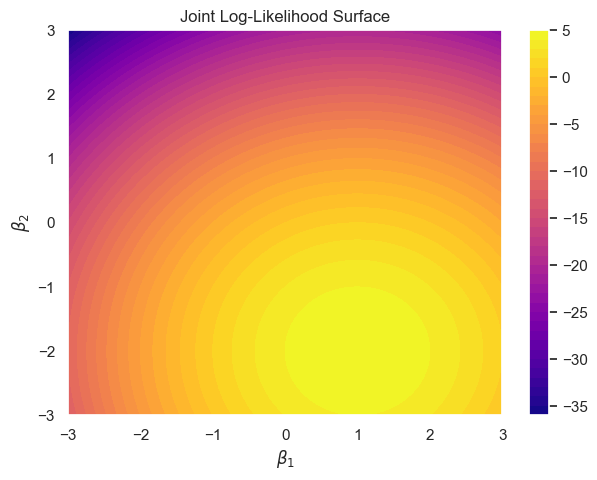

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Example beta values
b1 = np.linspace(-3, 3, 100)
b2 = np.linspace(-3, 3, 100)
B1, B2 = np.meshgrid(b1, b2)

# Example log-likelihood surface: simple synthetic example
LL = -((B1 - 1)**2 + (B2 + 2)**2) + 5

# Contour plot
plt.figure(figsize=(7, 5))
cp = plt.contourf(B1, B2, LL, levels=50, cmap='plasma')
plt.colorbar(cp)
plt.title('Joint Log-Likelihood Surface')
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.grid(True)
plt.show()


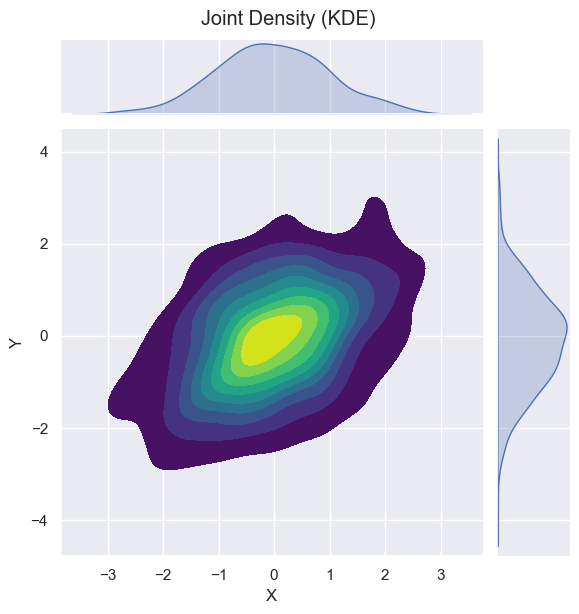

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Simulate continuous bivariate data
np.random.seed(0)
x = np.random.normal(0, 1, 500)
y = 0.5 * x + np.random.normal(0, 1, 500)

df = pd.DataFrame({'X': x, 'Y': y})

# Joint KDE plot
sns.jointplot(data=df, x='X', y='Y', kind='kde', fill=True, cmap='viridis')
plt.suptitle('Joint Density (KDE)', y=1.02)
plt.show()

## Parameter Estimation via Maximum Likelihood  

Once we have specified our multinomial logistic regression model, we estimate the parameters $\boldsymbol{\beta}$ using **maximum likelihood estimation (MLE)**.

### Log-Likelihood Function  

Suppose we have $n$ independent observations, and $K$ possible categories.

Let:
- $\mathbf{x}_i$ be the feature vector for observation $i$
- $y_i$ be the observed category for observation $i$
- $\pi_{ij} = P(Y = j \mid \mathbf{x}_i)$ be the predicted probability of class $j$ for observation $i$

Then, the **likelihood function** is:

$$
\mathcal{L}(\boldsymbol{\beta}) = \prod_{i=1}^n \prod_{j=1}^K \left(\pi_{ij}\right)^{\mathbb{1}(y_i = j)}
$$

Where $\mathbb{1}(y_i = j)$ is an indicator function equal to 1 if $y_i$ belongs to class $j$, and 0 otherwise.

**Log-Likelihood**  

Taking the natural logarithm of the likelihood function:

$$
\ln \mathcal{L}(\boldsymbol{\beta}) = \sum_{i=1}^n \sum_{j=1}^K \mathbb{1}(y_i = j) \ln \pi_{ij}
$$

---

### Substituting Model Probabilities  

**Baseline-category formulation** (with category $K$ as baseline):

For $j = 1, \dots, K-1$:

$$
\pi_{ij} = \frac{e^{\mathbf{x}_i^\top \boldsymbol{\beta}^{(j)}}}{1 + \sum_{l=1}^{K-1} e^{\mathbf{x}_i^\top \boldsymbol{\beta}^{(l)}}}
$$

and for $j = K$:

$$
\pi_{iK} = \frac{1}{1 + \sum_{l=1}^{K-1} e^{\mathbf{x}_i^\top \boldsymbol{\beta}^{(l)}}}
$$

**Softmax (symmetric) formulation**:

For all $j = 1, \dots, K$:

$$
\pi_{ij} = \frac{e^{\mathbf{x}_i^\top \boldsymbol{\beta}^{(j)}}}{\sum_{l=1}^{K} e^{\mathbf{x}_i^\top \boldsymbol{\beta}^{(l)}}}
$$

---

### Maximizing the Log-Likelihood  

We estimate the parameters $\boldsymbol{\beta}$ by finding the values that **maximize the log-likelihood**:

$$
\hat{\boldsymbol{\beta}} = \arg \max_{\boldsymbol{\beta}} \ \ln \mathcal{L}(\boldsymbol{\beta})
$$

Typically done using **numerical optimization methods** such as:
- Newton-Raphson
- Iteratively Reweighted Least Squares (IRLS)
- Quasi-Newton (BFGS / L-BFGS)
- Stochastic Gradient Descent (in deep learning libraries)

---

### Summary - Parameter Estimation  

- The multinomial log-likelihood generalizes the binary logistic regression likelihood.
- It’s a **sum over observations and classes**.
- The difference between baseline-category and softmax forms lies in how probabilities $\pi_{ij}$ are computed.
- Parameter estimation is done by maximizing this likelihood via iterative algorithms.

---

## Numerical Optimization Methods for Multinomial Logistic Regression

### Newton-Raphson Method

Iterative second-order optimization using the gradient and Hessian:

At each iteration $t$:

$$
\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} - \mathbf{H}^{-1}(\boldsymbol{\beta}^{(t)}) \, \nabla \ell(\boldsymbol{\beta}^{(t)})
$$

Where:  
- $\nabla \ell(\boldsymbol{\beta})$ is the gradient (first derivative) of the log-likelihood.  
- $\mathbf{H}(\boldsymbol{\beta})$ is the Hessian matrix (second derivative).

---

### Iteratively Reweighted Least Squares (IRLS)

A special case of Newton-Raphson applied to GLMs.  
Each iteration solves a weighted least squares problem:

At each iteration $t$:

$$
\boldsymbol{\beta}^{(t+1)} = \left( \mathbf{X}^\top \mathbf{W}^{(t)} \mathbf{X} \right)^{-1} \mathbf{X}^\top \mathbf{W}^{(t)} \mathbf{z}^{(t)}
$$

Where:  
- $\mathbf{W}^{(t)}$ is a diagonal weight matrix based on current predicted probabilities.  
- $\mathbf{z}^{(t)}$ is the adjusted dependent variable ("working response").

---

### Gradient Descent

First-order optimization using only the gradient:

At each iteration $t$:

$$
\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} + \alpha \, \nabla \ell(\boldsymbol{\beta}^{(t)})
$$

Where:  
- $\alpha$ is the learning rate.  
- $\nabla \ell(\boldsymbol{\beta})$ is the gradient of the log-likelihood.

---

### Stochastic Gradient Descent (SGD)

Uses a single observation (or mini-batch) at each step for updates:

At iteration $t$, with observation $i_t$:

$$
\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} + \alpha \, \nabla \ell_{i_t}(\boldsymbol{\beta}^{(t)})
$$

Where:  
- $\ell_{i_t}(\boldsymbol{\beta})$ is the log-likelihood contribution from observation $i_t$.

---

### Quasi-Newton Methods (e.g., BFGS, L-BFGS)

Approximate the Hessian matrix instead of computing it explicitly:

$$
\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} - \mathbf{B}^{(t)} \, \nabla \ell(\boldsymbol{\beta}^{(t)})
$$

Where:  
- $\mathbf{B}^{(t)}$ is an approximation to the inverse Hessian updated iteratively.

---

### Summary Table - Optimisation Methods

| Method                        | Update Equation                                                                                              | Uses Hessian?       |
|------------------------------|-------------------------------------------------------------------------------------------------------------|--------------------|
| **Newton-Raphson**            | $\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} - \mathbf{H}^{-1} \, \nabla \ell(\boldsymbol{\beta})$ | Yes                |
| **IRLS**                     | $\boldsymbol{\beta}^{(t+1)} = (\mathbf{X}^\top \mathbf{W} \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{W} \mathbf{z}$ | Yes (via GLM)       |
| **Gradient Descent**          | $\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} + \alpha \, \nabla \ell(\boldsymbol{\beta})$          | No                 |
| **Stochastic Gradient Descent** | $\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} + \alpha \, \nabla \ell_{i_t}(\boldsymbol{\beta})$    | No                 |
| **Quasi-Newton (BFGS)**       | $\boldsymbol{\beta}^{(t+1)} = \boldsymbol{\beta}^{(t)} - \mathbf{B}^{(t)} \, \nabla \ell(\boldsymbol{\beta})$ | Approximate Hessian |



In [12]:
def log_likelihood(beta1, beta2):
    ll = 0
    for i in range(len(X)):
        z = np.array([beta1 * X[i], beta2 * X[i], 0])  # 3 classes, fix beta3 = 0 for identifiability
        p = softmax(z)
        ll += np.log(p[y[i]])
    return ll


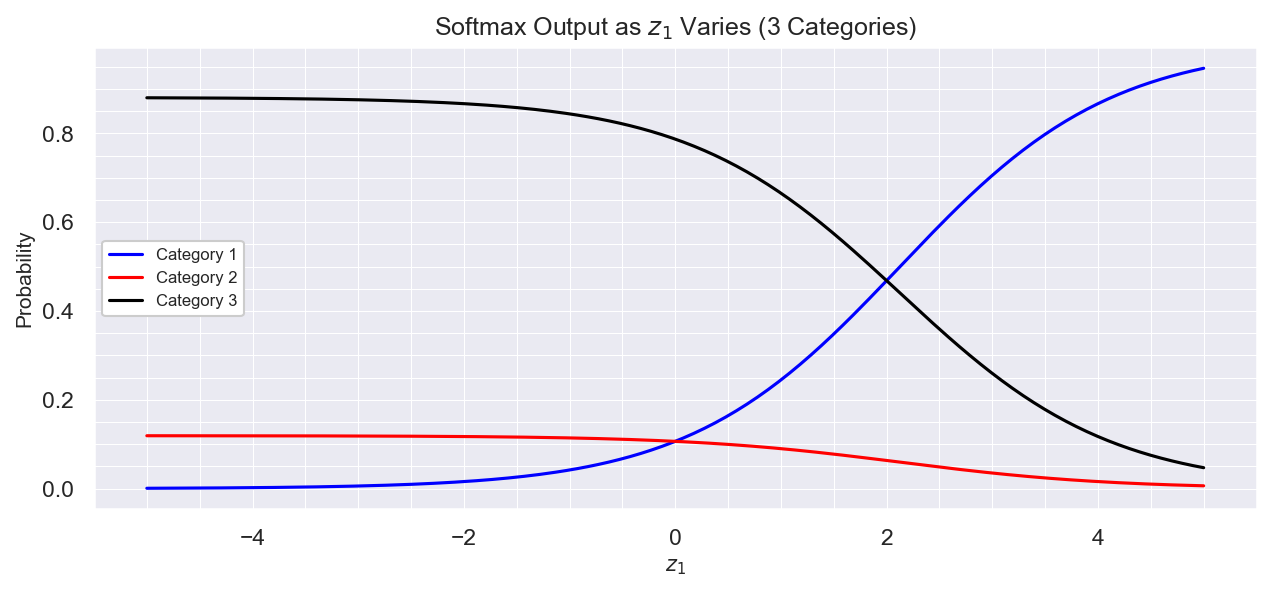

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Vary z1 while keeping z2 and z3 constant
z1_values = np.linspace(-5, 5, 200)
probs = []

for z1 in z1_values:
    z = np.array([z1, 0, 2])  # Fix z2 and z3 at 0 and 2
    probs.append(softmax(z))

probs = np.array(probs)

# Prepare tidy DataFrame for seaborn
df = pd.DataFrame({
    'z1': np.repeat(z1_values, 3),
    'Probability': probs.flatten(),
    'Category': np.tile(['Category 1', 'Category 2', 'Category 3'], len(z1_values))
})

# Plot with seaborn
plt.figure(figsize=(10, 4), dpi=150)
sns.lineplot(data=df, x='z1', y='Probability', hue='Category', palette=['blue', 'red', 'black'], linewidth = 1.5)
sns.set_theme()


plt.grid(which='both', linestyle='-', linewidth=0.5) # Enable major and minor grid lines
plt.minorticks_on() # Turn on minor ticks for both axes to get more grid lines
plt.title('Softmax Output as $z_1$ Varies (3 Categories)', fontsize= 12)
plt.xlabel('$z_1$', fontsize = 10)
plt.ylabel('Probability', fontsize = 10)
plt.legend(facecolor='white', loc = 'center left', framealpha=1,  fontsize = 8)

plt.show()

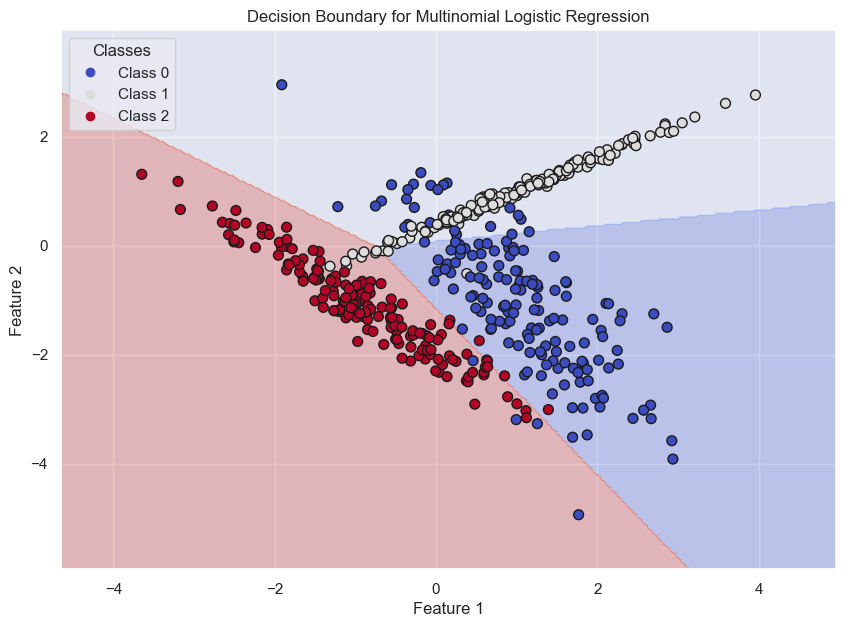

In [14]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Generate synthetic 2D data for 3 classes
X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1,
                           n_classes=3, random_state=42)

# Train multinomial logistic regression with 'lbfgs' solver
model = LogisticRegression(solver='lbfgs')
model.fit(X, y)

# Plotting decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)
preds = np.argmax(probs, axis=1).reshape(xx.shape)

plt.figure(figsize=(10, 7))
# Plot decision boundary by coloring regions
plt.contourf(xx, yy, preds, alpha=0.3, cmap='coolwarm')

# Plot training points
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k', cmap='coolwarm')

plt.title('Decision Boundary for Multinomial Logistic Regression')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Legend for classes
handles = scatter.legend_elements()[0]
labels = [f'Class {i}' for i in range(3)]
plt.legend(handles, labels, title='Classes')

plt.show()



### 📌 Intuition

- For each observation $i$, only one term in the sum over $k$ is non-zero — the one for the true class.
- Effectively, for each observation, you take the log of the predicted probability for the true class, multiply by $-1$, and sum across all observations.
- The optimizer adjusts $\boldsymbol{\beta}^{(k)}$ values to maximize the probability assigned to the correct class (minimizing this loss).

---

### 📌 Why It’s Called “Cross-Entropy”

This loss computes the **cross-entropy** between:
- The true label distribution (one-hot vector: 1 for the correct class, 0 for others)
- And the predicted probability distribution (output by softmax)

The general formula for cross-entropy between distributions $p$ and $q$:

$$
H(p, q) = - \sum_{i=1}^n \sum_{k=1}^K p_{ik} \ln q_{ik}
$$

In this case:
- $p_{ik} = I(y_i = k)$ (true labels)
- $q_{ik} = P(y_i = k \mid \mathbf{x}_i)$ (predicted probability)

Which is exactly the same formula we just derived.

---

In [15]:
from sklearn.datasets import fetch_california_housing

# Import California Housing Data
data = fetch_california_housing()

# Print description of dataset
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import mord
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create features and targets
X = data.data
y_continuous = data.target

In [17]:
import pandas as pd

df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


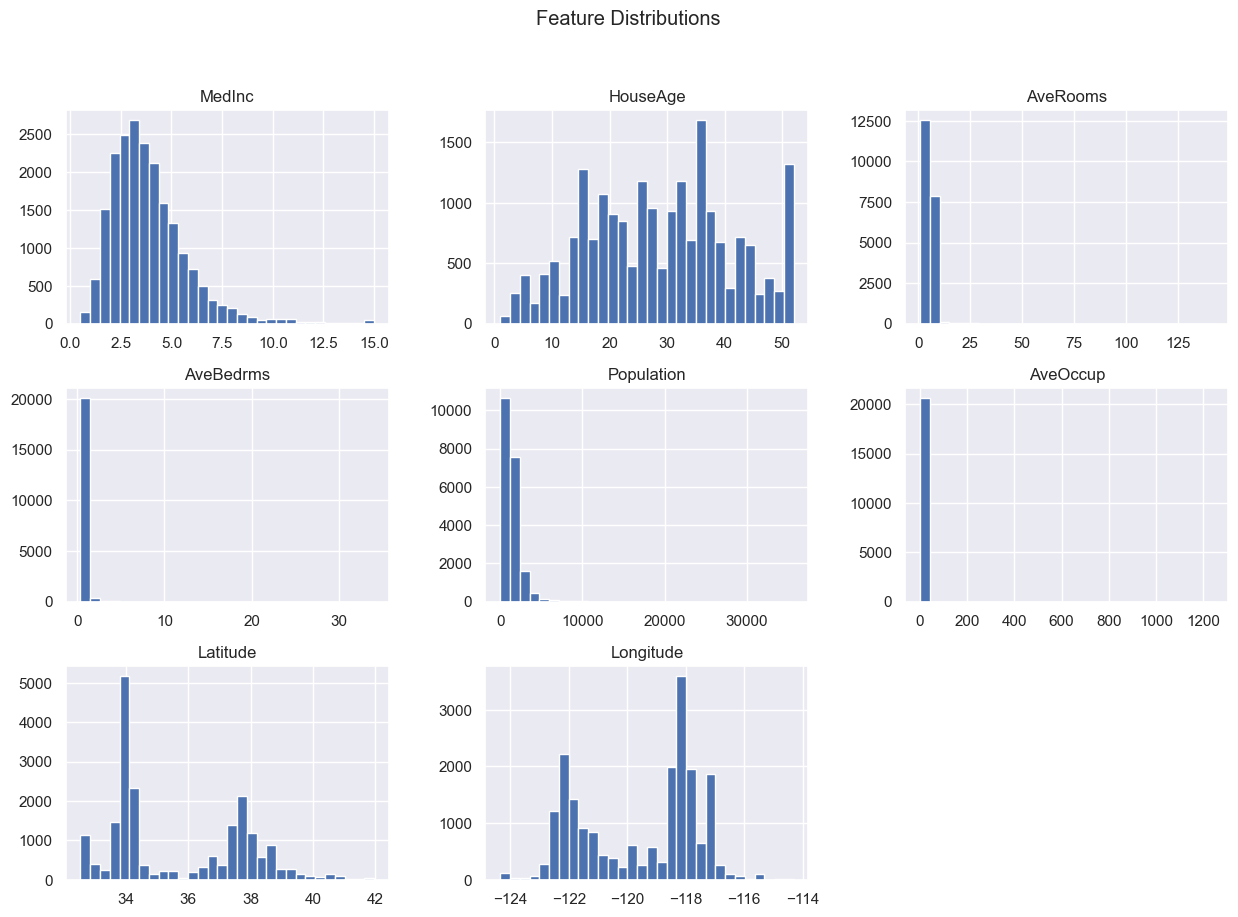

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(data.data, columns=data.feature_names)

df.hist(bins=30, figsize=(15,10))
plt.suptitle('Feature Distributions')
plt.show()


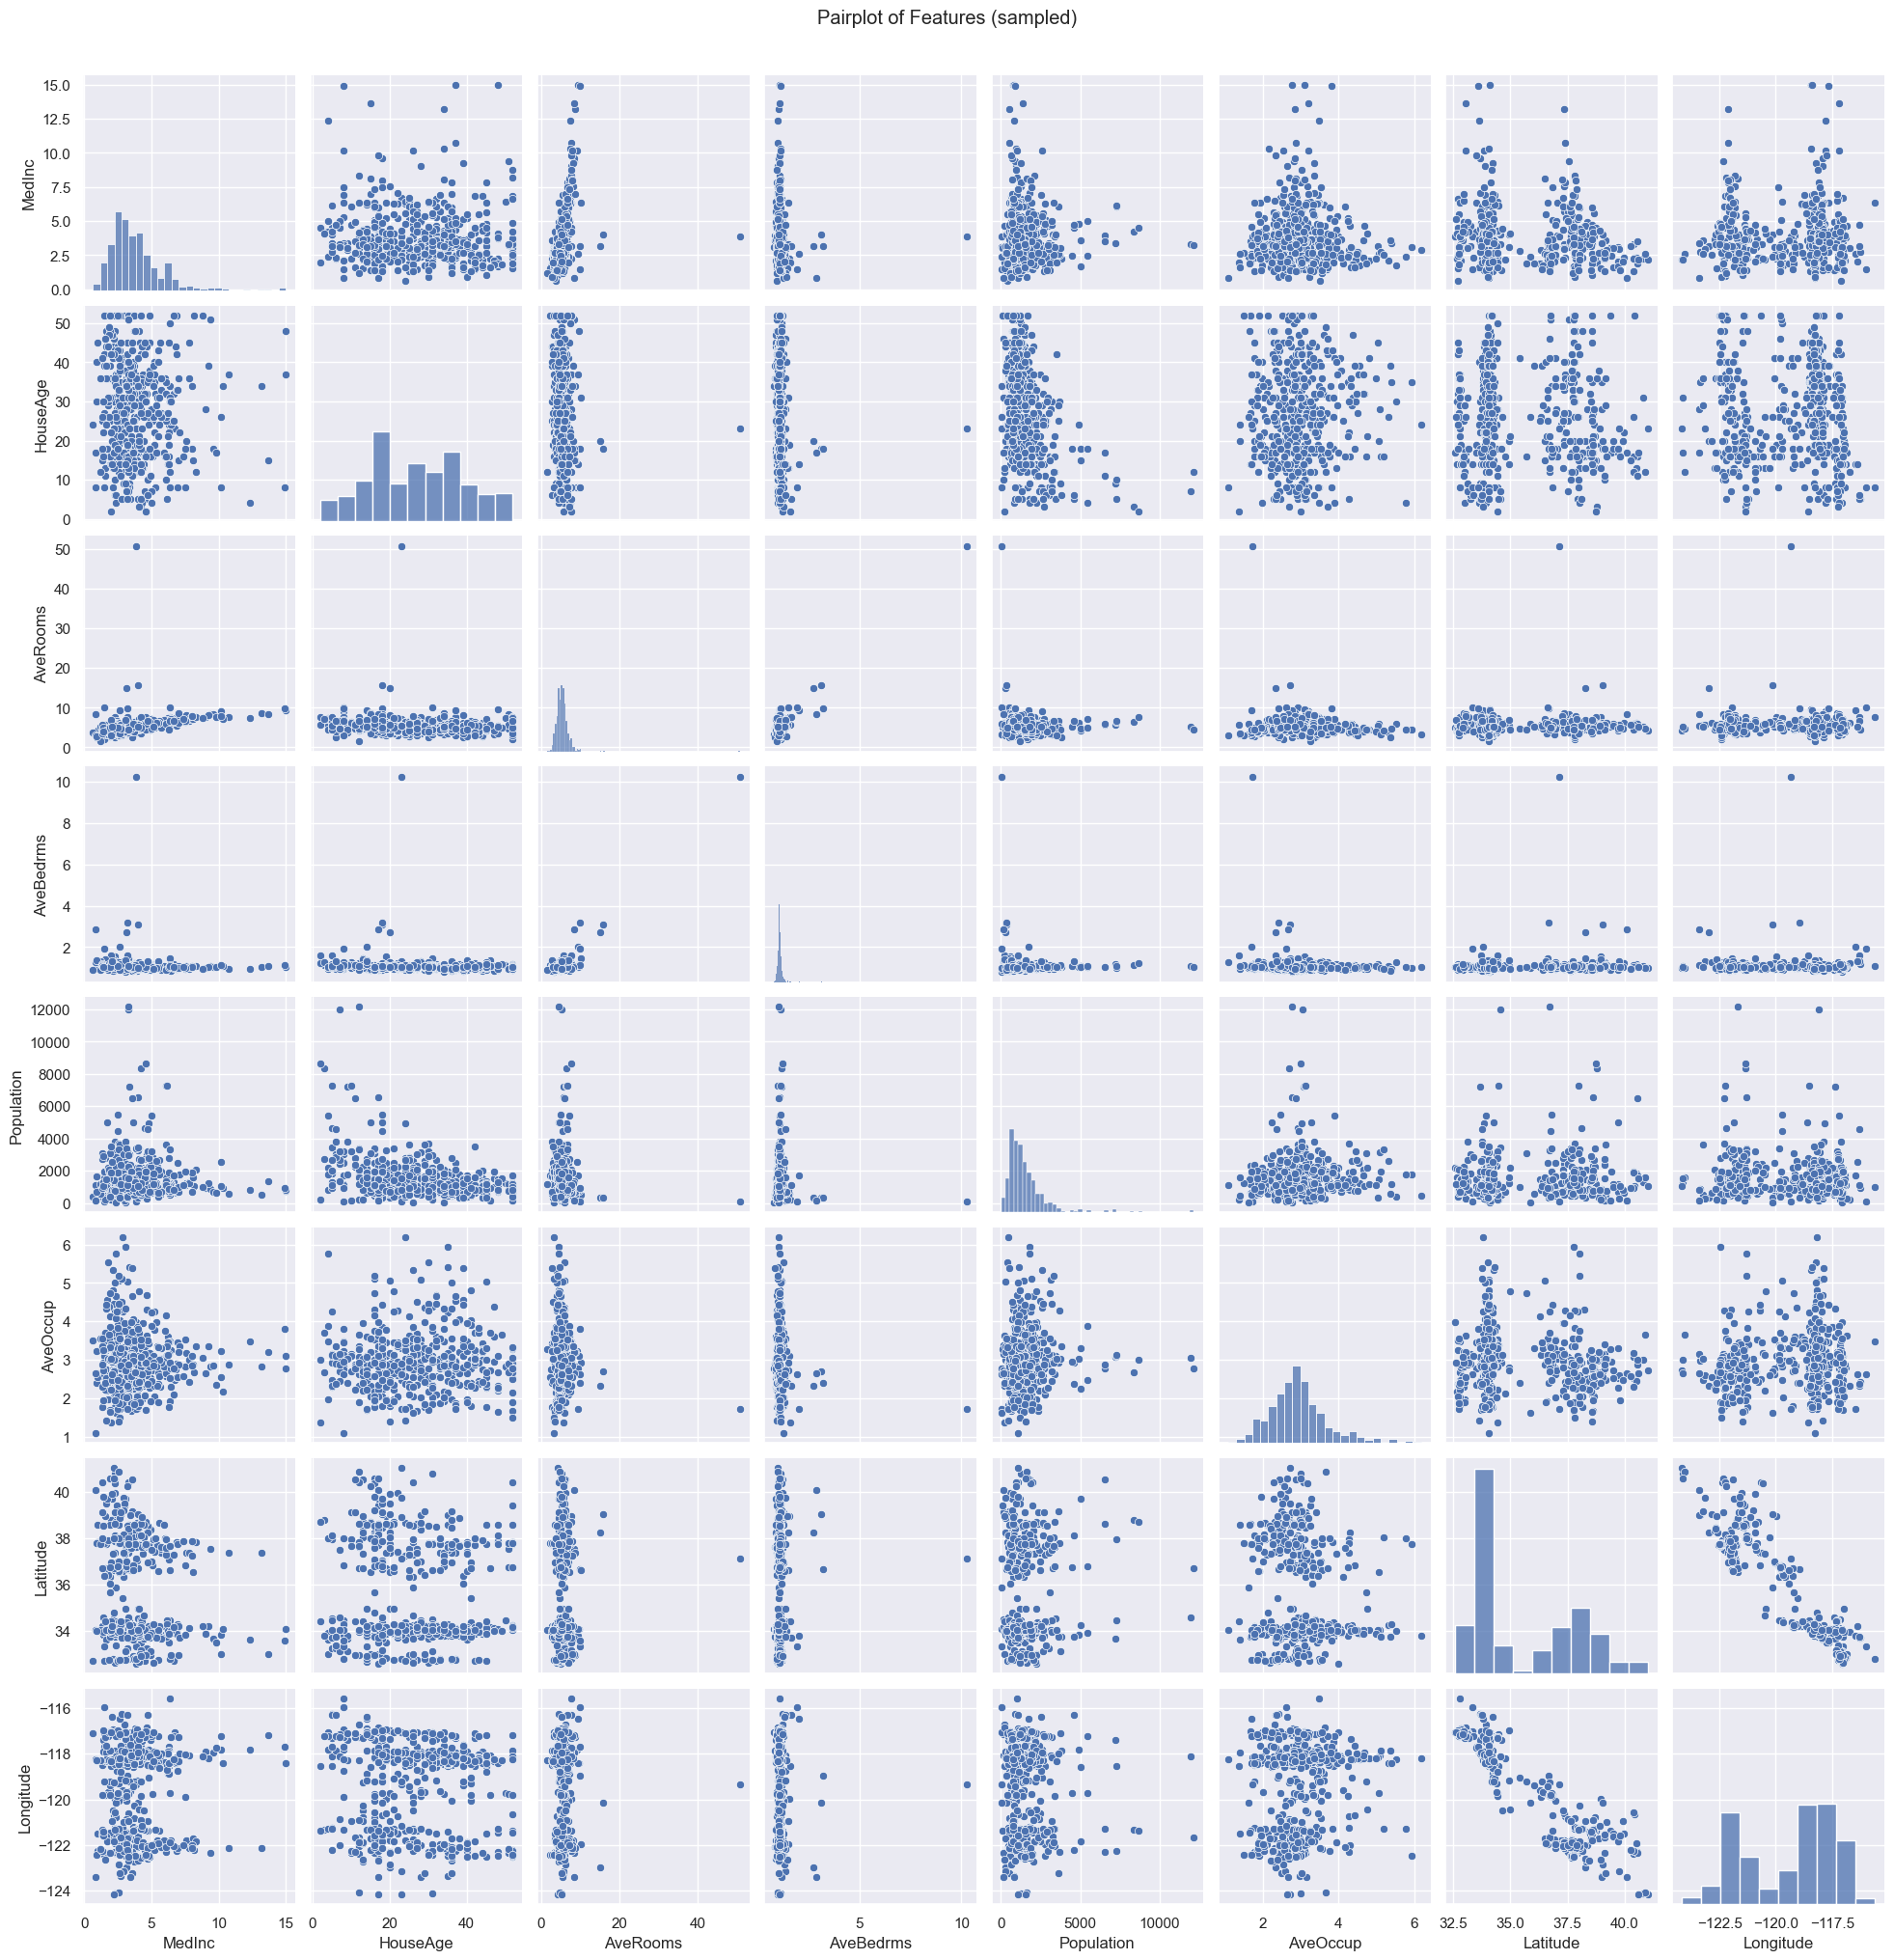

In [19]:
sns.pairplot(df.sample(500))  # Sample 500 rows to keep it fast
plt.suptitle('Pairplot of Features (sampled)', y=1.02)
plt.show()


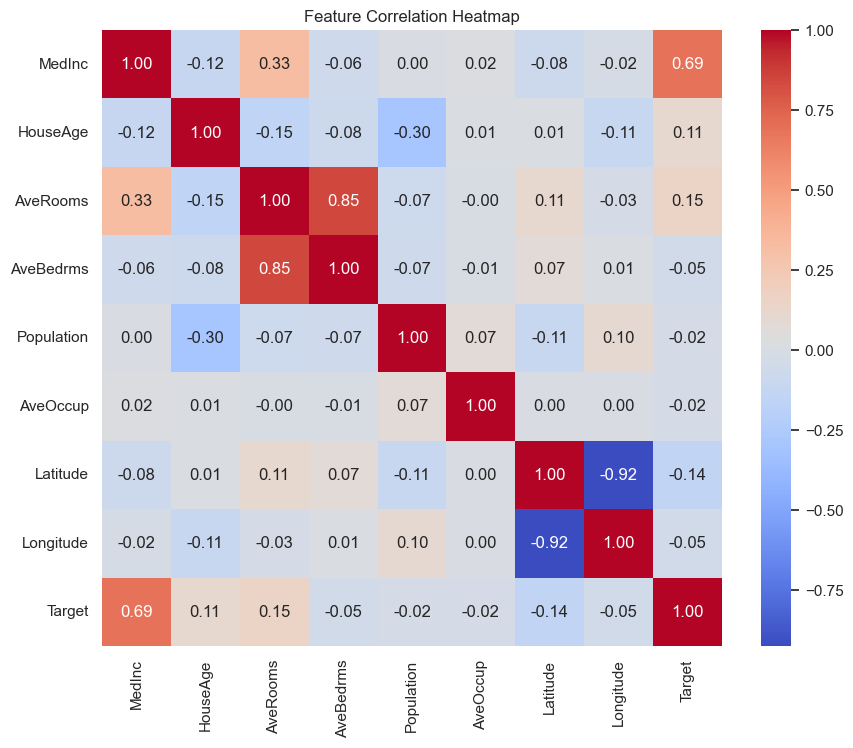

In [20]:
df['Target'] = data.target
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


In [21]:
# Bin target into 3 ordinal categories: Low=0, Medium=1, High=2
y_ordinal = pd.qcut(y_continuous, q=3, labels=[0,1,2]).astype(int)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_ordinal, test_size=0.3, random_state=42)


In [22]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [23]:
# Initialize and fit ordinal logistic regression (LogisticAT = All Threshold)
model = mord.LogisticAT()
model.fit(X_train_scaled, y_train)


LogisticAT()

In [24]:
# Predict on test set
y_pred = model.predict(X_test_scaled)


In [25]:
# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      2061
           1       0.55      0.70      0.61      2049
           2       0.80      0.69      0.74      2082

    accuracy                           0.70      6192
   macro avg       0.72      0.70      0.71      6192
weighted avg       0.72      0.70      0.71      6192



In [26]:
# Original continuous target
y_continuous = data.target

# Create bins (the same way you did)
bins = pd.qcut(y_continuous, q=3, retbins=True)[1]
print("Bin edges for median house value:")
print(bins)

Bin edges for median house value:
[0.14999    1.414      2.30333333 5.00001   ]


In [27]:
categories = ['Low', 'Medium', 'High']
bin_ranges = [f"${bins[i]:.2f} - ${bins[i+1]:.2f}" for i in range(len(bins)-1)]

summary_df = pd.DataFrame({
    'Category': categories,
    'Value Range': bin_ranges
})
print(summary_df)

  Category    Value Range
0      Low  $0.15 - $1.41
1   Medium  $1.41 - $2.30
2     High  $2.30 - $5.00


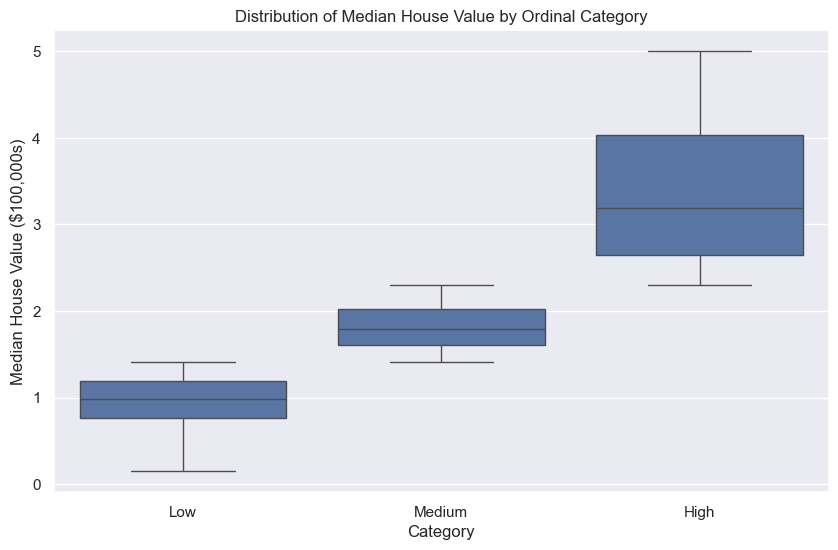

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your ordinal target variable
y_ordinal = pd.qcut(y_continuous, q=3, labels=[0,1,2]).astype(int)

df_viz = pd.DataFrame({'MedianHouseValue': y_continuous, 'Category': y_ordinal})

plt.figure(figsize=(10,6))
sns.boxplot(x='Category', y='MedianHouseValue', data=df_viz)
plt.xticks([0,1,2], ['Low', 'Medium', 'High'])
plt.title('Distribution of Median House Value by Ordinal Category')
plt.ylabel('Median House Value ($100,000s)')
plt.xlabel('Category')
plt.show()


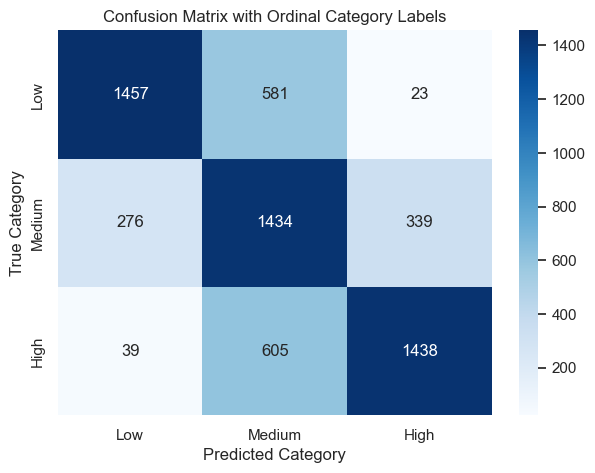

In [29]:
# Assuming y_test and y_pred are your true and predicted ordinal labels

cm = confusion_matrix(y_test, y_pred)

category_names = ['Low', 'Medium', 'High']

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_names,
            yticklabels=category_names)

plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix with Ordinal Category Labels')
plt.show()

In [30]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load Wine dataset
wine = load_wine()
X = wine.data
y = wine.target
class_names = wine.target_names  # ['class_0', 'class_1', 'class_2']

# Split data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multinomial Logistic Regression
model = LogisticRegression(solver='lbfgs', max_iter=500)
model.fit(X_train_scaled, y_train)

# Predict on test
y_pred = model.predict(X_test_scaled)

# Print classification report
print(classification_report(y_test, y_pred, target_names=class_names))



              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        19
     class_1       1.00      0.95      0.98        21
     class_2       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



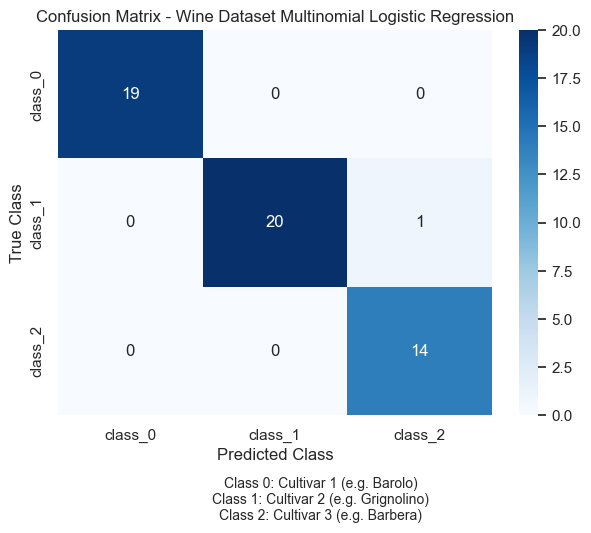

In [31]:
import matplotlib.pyplot as plt


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - Wine Dataset Multinomial Logistic Regression')

# Add explicit class mapping below the plot
class_mapping = "\n".join([
    "Class 0: Cultivar 1 (e.g. Barolo)",
    "Class 1: Cultivar 2 (e.g. Grignolino)",
    "Class 2: Cultivar 3 (e.g. Barbera)"
])

plt.gcf().text(0.5, -0.1, class_mapping, ha='center', fontsize=10)
plt.show()


## Ordinal Logistic Regression

Instead of modeling the probability of being in one category directly, it models the **cumulative probability** of being in category *j* or below:

$$
\log \left( \frac{P(y \leq j)}{P(y > j)} \right) = \theta_j - \beta^\top X
$$

Where:
- $\theta_j$ is a **threshold** specific to category *j*
- $\beta$ is the set of coefficients for predictors (same for all thresholds)
- Assumes the **proportional odds assumption**: the effect of predictors is constant across the different cumulative logits


---

In [32]:
import pandas as pd


sales_data = pd.read_csv('../Regression Models/sales_data.csv')

In [33]:
sales_data.describe()

,Inventory Level,Units Sold,Units Ordered,Price,Discount,Promotion,Competitor Pricing,Epidemic,Demand
count,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000
mean,301.062842,88.827316,89.090645,67.726028,9.087039,0.328947,69.454029,0.200000,104.317158
std,226.510161,43.994525,162.404627,39.377899,7.475781,0.469834,40.943818,0.400003,46.964801
min,0.000000,0.000000,0.000000,4.740000,0.000000,0.000000,4.290000,0.000000,4.000000
25%,136.000000,58.000000,0.000000,31.997500,5.000000,0.000000,32.620000,0.000000,71.000000
50%,227.000000,84.000000,0.000000,64.500000,10.000000,0.000000,65.700000,0.000000,100.000000
75%,408.000000,114.000000,121.000000,95.830000,10.000000,1.000000,97.932500,0.000000,133.000000
max,2267.000000,426.000000,1616.000000,228.030000,25.000000,1.000000,261.220000,1.000000,430.000000


In [34]:
#import the basic libraries
import numpy as np
import pandas as pd
#get the wine dataset from sklearn and take a look at the description provided
from sklearn import datasets
wine = datasets.load_wine()
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [35]:
sales_data.nunique()

Date                    760
Store ID                  5
Product ID               20
Category                  5
Region                    4
Inventory Level        1426
Units Sold              330
Units Ordered           996
Price                 15396
Discount                  6
Weather Condition         4
Promotion                 2
Competitor Pricing    15963
Seasonality               4
Epidemic                  2
Demand                  340
dtype: int64

In [36]:
sales_data.describe(include='all')

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
count,76000,76000,76000,76000,76000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000,76000.000000,76000.000000,76000,76000.000000,76000.000000
unique,760,5,20,5,4,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,4,NaN,NaN
top,2022-01-01,S001,P0001,Groceries,North,NaN,NaN,NaN,NaN,NaN,Cloudy,NaN,NaN,Winter,NaN,NaN
freq,100,15200,3800,30400,30400,NaN,NaN,NaN,NaN,NaN,24360,NaN,NaN,21000,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,301.062842,88.827316,89.090645,67.726028,9.087039,NaN,0.328947,69.454029,NaN,0.200000,104.317158
std,NaN,NaN,NaN,NaN,NaN,226.510161,43.994525,162.404627,39.377899,7.475781,NaN,0.469834,40.943818,NaN,0.400003,46.964801
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,4.740000,0.000000,NaN,0.000000,4.290000,NaN,0.000000,4.000000
25%,NaN,NaN,NaN,NaN,NaN,136.000000,58.000000,0.000000,31.997500,5.000000,NaN,0.000000,32.620000,NaN,0.000000,71.000000
50%,NaN,NaN,NaN,NaN,NaN,227.000000,84.000000,0.000000,64.500000,10.000000,NaN,0.000000,65.700000,NaN,0.000000,100.000000
75%,NaN,NaN,NaN,NaN,NaN,408.000000,114.000000,121.000000,95.830000,10.000000,NaN,1.000000,97.932500,NaN,0.000000,133.000000


In [37]:
from sklearn.datasets import fetch_openml

# Example: Adult Income dataset (48K rows)
data = fetch_openml('Corporate-Credit-Rating', version=1, as_frame=True)
df = data.frame

print(df.shape)
print(df.head())


(2029, 31)
  Rating                   Name Symbol                 Rating_Agency_Name  \
0      A  Whirlpool Corporation    WHR         Egan-Jones Ratings Company   
1    BBB  Whirlpool Corporation    WHR         Egan-Jones Ratings Company   
2    BBB  Whirlpool Corporation    WHR                      Fitch Ratings   
3    BBB  Whirlpool Corporation    WHR                      Fitch Ratings   
4    BBB  Whirlpool Corporation    WHR  Standard  Poor's Ratings Services   

         Date             Sector  currentRatio  quickRatio  cashRatio  \
0  11/27/2015  Consumer Durables      0.945894    0.426395   0.099690   
1   2/13/2014  Consumer Durables      1.033559    0.498234   0.203120   
2    3/6/2015  Consumer Durables      0.963703    0.451505   0.122099   
3   6/15/2012  Consumer Durables      1.019851    0.510402   0.176116   
4  10/24/2016  Consumer Durables      0.957844    0.495432   0.141608   

   daysOfSalesOutstanding  ...  effectiveTaxRate  \
0               44.203245  ...     

In [38]:
df.describe(include='all')

,Rating,Name,Symbol,Rating_Agency_Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
count,2029,2029,2029,2029,2029,2029,2029.000000,2029.000000,2029.000000,2029.000000,...,2029.000000,2029.000000,2.029000e+03,2.029000e+03,2029.000000,2029.000000,2029.000000,2.029000e+03,2029.000000,2029.000000
unique,10,593,593,5,904,12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,BBB,"BCE, Inc.",BCE,Standard Poor's Ratings Services,6/15/2012,Energy,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,671,7,7,744,223,294,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,3.529607,2.653986,0.667364,333.795606,...,0.397572,0.409550,5.094719e+03,4.227549e+03,3.323579,0.437454,48.287985,6.515123e+03,1.447653,38.002718
std,NaN,NaN,NaN,NaN,NaN,NaN,44.052361,32.944817,3.583943,4447.839583,...,10.595075,3.796488,1.469156e+05,1.224000e+05,87.529866,8.984299,529.118961,1.775290e+05,19.483294,758.923588
min,NaN,NaN,NaN,NaN,NaN,NaN,-0.932005,-1.893266,-0.192736,-811.845623,...,-100.611015,-120.916010,-4.912742e+03,-1.915035e+01,-2555.419643,-124.343612,-3749.921337,-1.195049e+04,-4.461837,-76.662850
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.071930,0.602825,0.130630,22.905093,...,0.146854,0.271478,4.119924e-01,1.566038e+00,2.046822,0.028057,6.238066,2.356735e+00,0.073886,2.205912
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.493338,0.985679,0.297493,42.374120,...,0.300539,0.644529,2.131742e+00,3.686513e+00,2.652456,0.087322,9.274398,4.352584e+00,0.133050,5.759722
75%,NaN,NaN,NaN,NaN,NaN,NaN,2.166891,1.453820,0.624906,59.323563,...,0.370653,0.836949,4.230253e+00,8.086152e+00,3.658331,0.149355,12.911759,7.319759e+00,0.240894,9.480892


In [39]:
df

,Rating,Name,Symbol,Rating_Agency_Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,BBB,"NVR, Inc.",NVR,Moody's Investors Service,9/5/2012,Capital Goods,11.757767,7.115059,7.057420,1.079762,...,0.343500,0.953231,50.293155,230.194971,1.759461,0.086376,15.867701,52.760726,0.083018,15.758348
2025,BB,Kaiser Aluminum Corporation,KALU,Standard Poor's Ratings Services,4/28/2016,Capital Goods,2.962788,1.294743,0.428234,30.602414,...,0.363636,0.602645,5.563630,5.958956,1.614282,-0.267117,-4.729967,9.232021,0.114089,14.542373
2026,B,Cresud S.A.C.I.F. y A.,CRESY,Fitch Ratings,11/30/2012,Finance,0.883875,0.842553,0.233830,147.599372,...,35.017544,0.926665,1.459801,1.056480,4.034952,0.265092,9.358311,1.575328,0.283634,2.300168
2027,B,Cresud S.A.C.I.F. y A.,CRESY,Fitch Ratings,6/15/2012,Finance,0.911713,0.748356,0.310640,131.644566,...,0.331525,0.692804,0.744377,1.470201,3.825856,0.130692,22.440102,1.074441,0.217783,1.997608
